### Examining the Profiles
We'll start by loading the _Profiles_ table into Pandas and summarizing the table's contents

In [1]:
import pandas as pd

def summarize_table(df):
    n_rows, n_columns = df.shape
    summary = df.describe()
    print(f"The table contains {n_rows} rows and {n_columns} columns.")
    print("Table Summary:\n")
    print(summary.to_string())

df_profile = pd.read_csv('friendhook/Profiles.csv')
summarize_table(df_profile)

The table contains 4039 rows and 6 columns.
Table Summary:

          Profile_ID           Sex Relationship_Status          Dorm         Major          Year
count           4039          4039                3631          4039          4039          4039
unique          4039             2                   3            15            30             4
top     440af1812334  e807eb960650        ac0b88e46e20  a8e6e404d1b3  141d4cdd5aaf  c1a648750a4b
freq               1          2020                1963          2739          1366          1796


The table contains 4039 distinct profiles. The profiles are distributed across two different sexes. The most frequent sex is mentioned in 2020 of 4039 profiles. Hence, we can infer that the profiles represent an equal distribution between males and females. Furthemore, the profiles capture a student-body distribution that's spread across 30 majors and 15 dormatories. Suspiciously, the most frequently mentioned dorm contains over 2,700 students. This number seems large. However a quick Google search reveals that large on-campus student complexes are not uncommon. For instance, the 17 story Sandburg Residence Hall at the University of Wisconsin-Milwaukee can house 2,700 students. Additionally, its possible that these numbers represent students in withen the _Offcampus Housing_ category. Hence, the count can be explained by a multitude of hypothesis. Nonetheless, going forward, we should consider the various driving factors behind the numbers we observe. Rather than blindly crunching numbers, we should keep in mind that our data is derived from real-world behaviors and and physical constraints of university students.

There is one place in the table summary where the numbers are off; the _Relationship Status_ column. Pandas has detected three _Relationship Status_ categories across 3631 of 4039 table rows. The remaining 400 or so rows are null. They don't contain any assigned relationship status. Lets count the total number of empty rows.

In [2]:
is_null = df_profile.Relationship_Status.isnull()
num_null = df_profile[is_null].shape[0]
print(f"{num_null} profiles are missing the Relationship Status field.")

408 profiles are missing the Relationship Status field.


408 profiles do not contain a listed relationship status. This makes. As stated in the problem statement, the _Relationship Status_ field is optional. Thus, one-tenth of the students refused to specify that field. Notheneless, we cannot continue our analysis with empty values in our data. We need to either delete the empty rows or replace the empty fields with some other value. Deleting the empty rows is not a good option. We'd be throwing out potentially value information within the other columns. Instead, we can treat the lack of status as a fourth _unspecified_ relationship status category. Hence, we should assign these rows a category id. What id value should we choose? Before we answer the question, lets examine all unique ids within the _Relationship Status_ column.

In [3]:
unique_ids = set(df_profile.Relationship_Status.values)
print(unique_ids)

{nan, '9cea719429e9', 'ac0b88e46e20', '188f9a32c360'}


In [4]:
df_profile.Relationship_Status.values

array(['9cea719429e9', 'ac0b88e46e20', 'ac0b88e46e20', ...,
       'ac0b88e46e20', 'ac0b88e46e20', '9cea719429e9'], dtype=object)

As expected, the _Relationship Status_ values are composed of three hash codes and an empty `nan`. The hash codes are encrypted versions of the three possible status categories; _Single_, _In a Relationship_, and _Its Complicated_. We of course, don't know which category is which. All we can determine is whether two profiles fall within the same status category. Our aim is to eventually leverage this information within a trained machine learning model. However, the Scikit-Learn library is unable to process hash-codes or null values. It can only process numbers. Hence, we'll need to eventually convert the categories to numeric values. The simplest solution would be to assign each category a number between `0` and `4`. Lets execute this assignment. We'll start by generating a dictionary mapping between each category and number.

In [5]:
import numpy as np
#unique_ids = sorted(unique_ids, key=lambda x: x if not np.isnan(x) else '')
#category_map = {id_: i for i, id_ in enumerate(unique_ids)}
#print(category_map)
category_map = {'9cea719429e9': 0, np.nan: 1, '188f9a32c360': 2, 
                'ac0b88e46e20': 3}

Next, we'll replace the contents of the _Relationship Status_ column with the appropriate numeric values.

In [6]:
nums = [category_map[hash_code] 
        for hash_code in df_profile.Relationship_Status.values]
df_profile['Relationship_Status'] = nums
print(df_profile.Relationship_Status)

0       0
1       3
2       3
3       3
4       0
       ..
4034    3
4035    0
4036    3
4037    3
4038    0
Name: Relationship_Status, Length: 4039, dtype: int64


We've transformed _Relationship Status_ into a numeric variable. However, the remaining five columns in the table still contain hash-codes. Should we the also replace these hash-codes with numbers? Yes! Here's why:

1. As previously mentioned, Scikit-Learn cannot process strings or hashes. It only takes numeric values as input.
2. For humans, reading hash-codes is more mentally taxing than reading numbers. Thus, replacing the multi-character codes with shorter numbers will make it easier for us to explore the data.

With this in mind, lets create a category mapping between hash-codes and numbers in each column. We'll track the category mappings in each column with a `col_to_mapping` dictionary. We'll also leverage the mappings in order to replace all hash-codes with numbers in `df_profile`.

In [7]:
col_to_mapping = {'Relationship_Status': category_map}

for column in df_profile.columns:
    if column in col_to_mapping:
        continue
        
    unique_ids = sorted(set(df_profile[column].values))
    category_map = {id_: i for i, id_ in enumerate(unique_ids)}
    col_to_mapping[column] = category_map
    nums = [category_map[hash_code] 
            for hash_code in df_profile[column].values]
    df_profile[column] = nums

head = df_profile.head()
print(head.to_string(index=False))

 Profile_ID  Sex  Relationship_Status  Dorm  Major  Year
       2899    0                    0     5     13     2
       1125    0                    3    12      6     1
       3799    0                    3    12     29     2
       3338    0                    3     4     25     0
       2007    1                    0    12      2     0


We've finished tweaking the `df_profile`. Now lets turn our attention to the table of experimental observations.

### Exploring the Experimental Observations
We'll start by loading the _Observations_ table into Pandas and summarizing the table's contents.

In [8]:
df_obs = pd.read_csv('friendhook/Observations.csv')
summarize_table(df_obs)

The table contains 4039 rows and 5 columns.
Table Summary:

          Profile_ID Selected_Friend Selected_Friend_of_Friend Friend_Request_Sent Friend_Request_Accepted
count           4039            4039                      4039                4039                    4039
unique          4039            2219                      2327                   2                       2
top     440af1812334    89581f99fa1e              6caa597f13cc                True                    True
freq               1              77                        27                2519                    2460


The five table columns all consistantly show 4039 filled rows. There are no empty values in the table. This is good. However, the actual column names are hard to read. The names are very descriptive, but also very long. We should consider shortening some of the names in order to ease our cognitive load. Lets briefly discuss the various columns and whether some renaming would be appropriate.

1. _Profile_ID_
    * The ID of the user who recieved the friend suggestion. This name is short and straightforward. It also corresponds to the _Profile_ID_ column in `df_profile`. We should keep this name as-is.
2. _Selected_Friend_
* An existing friend of the user in the _Profile_ID_ column. We can simplify this column name to just _Friend_.
3. _Selected_Friend_of_Friend.
    * A randomly chosen friend of _Selected_Friend_ who was not yet of friend _Profile_ID_. In the experiment, this random friend-of-friend was a displayed as friend suggestion our user. We can rename this column as _Suggested_Friend_, or possibly _FoF_. Lets call the column _FoF_, because this acronym is memorable and short.
4. _Friend_Requent_Sent_
    * This Boolean column is True if a user sends a friend request to the suggested friend-of-a-friend. It is False otherwise. Lets shorten the column name to just _Sent_.
5. _Friend_Requet_Sent
   * This Boolean column is only True if user sends a friend request and that requested is accepted. We can shorten the column name to _Accepted_.
   
Based on our discussion, we'll need rename four of the five columns. Lets rename the columns and regenerate the summary.

In [9]:
new_names = {'Selected_Friend': 'Friend', 
             'Selected_Friend_of_Friend': 'FoF',
             'Friend_Request_Sent': 'Sent',
             'Friend_Request_Accepted': 'Accepted'}
df_obs = df_obs.rename(columns=new_names)
summarize_table(df_obs)

The table contains 4039 rows and 5 columns.
Table Summary:

          Profile_ID        Friend           FoF  Sent Accepted
count           4039          4039          4039  4039     4039
unique          4039          2219          2327     2        2
top     440af1812334  89581f99fa1e  6caa597f13cc  True     True
freq               1            77            27  2519     2460


In the updated table, the statistics are more clear. The observations contain 2219 unique _Friend_ ids and 2327 unique _FoF_ ids (out of 4039) samples total. This means that on average, each _Friend_ and _FoF_ id is utilized approximately twice. No single profile id dominates our data, which is reassuring. This will allow us to more easily design a robust predictive mode, as opposed to model which is driven by a single profile signal and thus more suseptable to overtraining. 

Further examination reveals that approximately 62% (2519) of the friend suggestions lead to friend request being sent. This is very promising; the friend-of-a-friend suggestions are quite effective. Furthermore, approximately 60% (2460) of sampled instances led to a friend request getting accepted. Hence, the sent friend requests are ignored or rejected just 2% (2519 - 2460 = 50) of the time. Of course, our numbers assume that there are no observations where _Sent_ is False and _Accepted_ is True. This scenerio is not possible, because a friend-request cannot be accepted if it has not yet been sent. Still, as sanity check, lets test the integrity of the data by confirm that the scenario does not take place.

In [10]:
condition = (df_obs.Sent == False) & (df_obs.Accepted == True)
assert not df_obs[condition].shape[0]

Based on our observations, user behavior follows three possible scenarios:
A. A user rejects or ignores the friend recommendation listed in the _FoF_ column.
 * This occurs in 38% of instances.
B. A user sends a friend-request based on the recommendation. The friend request is accepted.
  * This occurs in 62% of instances.
C. A user sends a friend-request based on the recommendation. The friend request is rejected or ignored.
  * This scenario is rare, occurring on just 1.2% of total instances.
  
Each of these three scenarios represents three categories of user behavior. Hence, we can encode this categorical behavior by assigning numbers `0`, `1`, and `2` to behavior patterns _A_, _B_, and _C_. Below, we'll carry out the categorial assignments, and store them in a _Behavior_ column.

In [11]:
behaviors = []
for sent, accepted in df_obs[['Sent', 'Accepted']].values:
    behavior = 2 if (sent and not accepted) else int(sent) * int(accepted)
    behaviors.append(behavior)
df_obs['Behavior'] = behaviors

Additionally, we must transform the profile ids in the first three columns from hash-codes to numeric ids that are consistent with `df_profile.Profile_ID`. Below, we'll utilize the mapping stored within `col_to_mapping['Profile_ID]` for this purpose.

In [12]:
for col in ['Profile_ID', 'Friend', 'FoF']:
    nums = [col_to_mapping['Profile_ID'][hash_code]
            for hash_code in df_obs[col]]
    df_obs[col] = nums

head = df_obs.head()
print(head.to_string(index=False))

 Profile_ID  Friend   FoF   Sent  Accepted  Behavior
       2485    2899  2847  False     False         0
       2690    2899  3528  False     False         0
       3904    2899  3528  False     False         0
        709    2899  3403  False     False         0
        502    2899   345   True      True         1


The `df_obs` now aligns with `df_profile`. Only a single data table remains unanalyzed. Lets proceed to explore the friendship linkages within the remaining _Friendships_ table.


### Exploring Friendships Linkage Table
We'll start by loading the _Friendships_ table into Pandas and summarizing the table's contents.

In [13]:
df_friends = pd.read_csv('friendhook/Friendships.csv')
summarize_table(df_friends)

The table contains 88234 rows and 2 columns.
Table Summary:

            Friend_A      Friend_B
count          88234         88234
unique          3646          4037
top     89581f99fa1e  97ba93d9b169
freq            1043           251


There are over 88,000 friendship links within this social network. Hence, the social network is quite dense, with an average of approximately 22 friends per FriendHook profile. One social butterfly in the network (_89581f99fa1e_) appears to have more than 1000 friends. However, an exact friend-count cannot be gagged because the two columns in the network are not symmetric. In fact, we cannot even validate whether all 4039 profiles are appropriately represented in the table.

In order to carry out a more detailed analysis, we should load the frienship data into a NetworkX graph. Below, we will compute the social graph. We'll represent the node ids with the numeric values that are mapped from the hash-codes within the columns. After we compute the graph, we'll count the number of nodes in `G.nodes`.

In [14]:
import networkx as nx
G = nx.Graph()
for id1, id2 in df_friends.values:
    node1 = col_to_mapping['Profile_ID'][id1]
    node2 = col_to_mapping['Profile_ID'][id2]
    G.add_edge(node1, node2)
    
nodes = list(G.nodes)
num_nodes = len(nodes)
print(f"The social graph contains {num_nodes} nodes.")

The social graph contains 4039 nodes.


The graph cotains 4039 nodes. We can infer that the 4039 profiles are fully represented within the social network.
[NOTE]
If any of these nodes contained ids that didn't align with profile hash-codes, then our previous efforts to map between the hash-codes and numeric values would have failed.

Lets try to gain more insights into the graph structure by visualizing it with `nx.draw`. Please note the graph is rather large, so visulization might take 10-30 seconds to load.

/Library/Python/3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


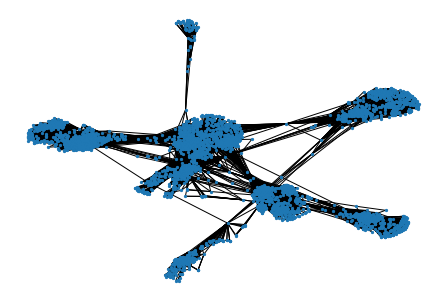

In [15]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)
nx.draw(G, node_size=5)
plt.show()

Tightly clustered social groups are clearly visible within the network. Lets extract these groups using Markov clustering. Afterwards, we'll count the number of clusters.

In [16]:
import markov_clustering as mc
matrix = nx.to_scipy_sparse_matrix(G)
result = mc.run_mcl(matrix)
clusters = mc.get_clusters(result) 
num_clusters = len(clusters)
print(f"{num_clusters} clusters were found in the social graph.")

10 clusters were found in the social graph.


Ten clusters were found in the social graph. Lets visualize these clusters by coloring each node based on cluster id. To start, we'll need to iterate over `clusters` and assign a `cluster_id` attribute to every node.

In [17]:
for cluster_id, node_indices in enumerate(clusters):
    for i in node_indices:
        node = nodes[i]
        G.nodes[node]['cluster_id'] = cluster_id

Next, we'll color the nodes based on their attribute assignment.

/Library/Python/3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


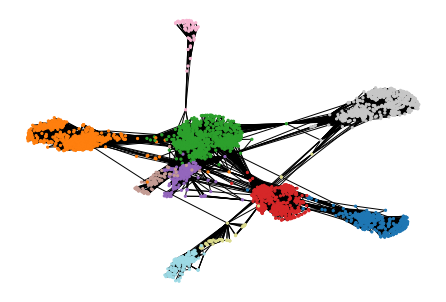

In [18]:
np.random.seed(0)
colors = [G.nodes[n]['cluster_id'] for n in G.nodes]
nx.draw(G, node_size=5, node_color=colors, cmap=plt.cm.tab20)
# plt.savefig('../images/fig22-2.png', dpi=600)
plt.show()

The cluster colors clearly correspond to tight social groups. Our clustering thus has been effective. Hence, the assigned `cluster_id` attributes should prove useful during the model-building process. In this same manner, it might be useful to store all five profile features as attributes within the student nodes. Lets iterate rows the columns of `df_profile` and store each column value within its corresponding node.

In [19]:
attribute_names = df_profile.columns
for attributes in df_profile.values:
    profile_id = attributes[0]
    for name, att in zip(attribute_names[1:], attributes[1:]):
        G.nodes[profile_id][name] = att
        
first_node = nodes[0]
print(f"Attributes of node {first_node}:")
print(G.nodes[first_node])

Attributes of node 2899:
{'cluster_id': 0, 'Sex': 0, 'Relationship_Status': 0, 'Dorm': 5, 'Major': 13, 'Year': 2}


We have finished exploring our input data. Now, we'll proceed to train a model that predicts user behavior. We'll start by constraining a simple model that only utilizes network features.

## Training a Predictive Model Using Network Features

Our goal is to train a supervised ML model on our dataset, in order to predict user behavior. Currently, all possible classes of behavior are stored within  the _Behavior_ columns of `df_obs`. Our three behavior class-labels are `0`, `1`, and `2`. As a reminder, the _Class 2_ label occurs in just 50 of the 4039 sampled instances. Hence, _Class 2_ is very imbalanced relative to the other class-labels. There is a case to be made for removing these 50 labeled examples from our training data altogether. However, for the time being, lets leave these examples in, just to see what happens. Later on, we will remove these examples, if necessary. For now, we will assign our training class-label array to equal the `df_obs.Behavior` column.

In [20]:
y = df_obs.Behavior.values
print(y)

[0 0 0 ... 1 1 1]


Now that we have class-labels, we'll need to create a feature-matrix `X`. Our goal is to populate this matrix with features arising from the social graph structure. Later, we'll add additional features from the student profiles. Hence, we don't need to assemble the feature-matrix all at once. We build-up the matrix slowly, adding new features in batches, in order to better understand the impact of these features on model performance. With this in mind, lets create an initial version of `X`, and populate it with some very basic features. The simplest question we can ask about an person within a social network is this; how many friends does the person have? Of course, that value equals edge-count associated with the person's node within the social graph. In other words, the friend-count is of person `n` is equal to `G.degree(n)`. Lets make the edge-count our first feature in the feature-matrix. We'll iterate over all the rows in `df_obs` and assign an edge-count to each profile that's referenced within each row. As a reminder, every row contains three profiles; _Profile_ID_, _Friend_ and _FoF_. We'll calculate the friend-count for each profile, creating features _Profile_ID_Edge_Count, _Friend_Edge_Count_, and _FoF_Edge_Count_.

[NOTE]
Its not always easy to come up with a good, consistent feature name. Rather than going with _FoF_Edge_Count_, we could have gone with _FoF_Friend_Count_. However, mantaining consistency would have forced us to include a _Friend_Friend_Count_ feature as well, hence leading to a very awkward feature name. Alternatively, we could have named our three feature _Profile_Degree_, _Friend_Degree_, and _FoF_Degree_. These names would be short and partially informative. However, its worth remembering that one of our profile features pertains to college majors. In the context of college, both degrees and majors have an nearly identical definition. Hence, a degree-based naming convention could cause confusion down the line. That is why we're sticking with _Edge_Count_.

Lets generate a matrix of 3-by-4039 edge-count features. We'll need a way to track these features along with the associated feature names. We'll also need a way to easily update features and their names with additional inputs. One straighforward solution is to store the features a `df_features` Pandas table. That table would allow to access the feature matrix via `df_features.values`. With this in mind, lets calculate the initial version of the feature matrix.

In [21]:
cols = ['Profile_ID', 'Friend', 'FoF']
features = {f'{col}_Edge_Count': [] for col in cols}
for node_ids in df_obs[cols].values:
    for node, feature_name in zip(node_ids, features.keys()):
        degree = G.degree(node)
        features[feature_name].append(degree)

df_features = pd.DataFrame(features)
X = df_features.values

We have an initial training set in-place. Lets quickly the quality of the signal in the training data by training and testing a simple model. We have multiple possible models to choose from. One sensible choice is a decision tree classifier. Decision trees can handle non-linear decision boundaries and are easily interpretable. On the downside, they are prone to over-training, so cross-validation will be required to measure model performance appropriately. We'll now train a decision tree on a subset of `(X, y)` and evaluate the results on the remaining data. During evaluation, we should keep in mind that our _Class 2_ labels are highly imbalanced. Thus, the f-measure metric will provide a more reasonable assesment of preformance, as opposed to simple accuracy.

[NOTE]
In the remainder of this section, will will repeatedly train and test our classifier models. Thus, we'll now define an `evaluate` function for this purpose. The function will take as input a training set `(X, y)` as well as model-type that's preset to `DecisionTreeClassifier`. The function will then split `X, y` into training and test sets. It will subsequently train the classifier, and compute an f-measure using the test set. Finally, it will return both the f-measure and the classifier for evalutation.

In [22]:
np.random.seed(0)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

def evaluate(X, y, model_type=DecisionTreeClassifier, **kwargs):
    np.random.seed(0)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    clf = model_type(**kwargs)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    f_measure = f1_score(pred, y_test, average='macro')
    return f_measure, clf

f_measure, clf = evaluate(X, y)
print(f"The f-measure is {f_measure:0.2f}")

The f-measure is 0.37


Our f-measure is terrible! Clearly, friend-count by itself is not a sufficient signal for predicting user-behavior. Perhaps a more sophisticated measure of node centrality is required. Earlier, we learned how the PageRank centrality measure can be more informative than edge-count. Perhaps adding PageRank values to our training set will yield improved results? Lets find out.

In [23]:
np.random.seed(0)
node_to_pagerank = nx.pagerank(G)
features = {f'{col}_PageRank': [] for col in cols}
for node_ids in df_obs[cols].values:
    for node, feature_name in zip(node_ids, features.keys()):
        pagerank = node_to_pagerank[node]
        features[feature_name].append(pagerank)

def update_features(new_features):
    for feature_name, values in new_features.items():
        df_features[feature_name] = values
    return df_features.values

X = update_features(features)
f_measure, clf = evaluate(X, y)

print(f"The f-measure is {f_measure:0.2f}")

The f-measure is 0.38


The f-measure remains approximately the same. Basic centrality measures are insufficient. We need to expand `X` to include the social groups uncovered by Markov Clustering. Afterall, two people in the same social group are more likely to be friends. How do we incoporate these social groups into the feature matrix? Well, naively we could assign the `cluster_id` attribute of referenced node as our social group feature. However, this approach has a serious downside. Our current cluster ids are only relevant to the specificial social graph within `G`. They are not at all relevant to any other college network. In other words, a model trained on the cluster ids in `G` will not be applicable to some other college graph within `G_other`. This won't do! One of our goals is construct a model that is generalizable to other colleges. Thus, we need a more nuanced solution.

One alternate approach is just consider the following binary question; are two people in the same social group? Yes or no? If they are, then perhaps they are more likely to eventually become friends on FriendHook. We can make this binary comparison between each pair of profile-ids within a single row of observations. More precisely we can ask whether:

1. The user in the `Profile_ID` column falls within the same social group as the friend in the _Friend_ column.
    * We'll name this feature _Shared_Cluster_id_f_. 
2. The user in the `Profile_ID` falls within the same social group as the friend-of-a-friend in the _FoF_ column.
    * We'll name this feature _Shared_Cluster_id_fof_. 
3. The friend in the _Friend_ column falls within the same social group as the friend-of-a-friend in the _FoF_ column.
    *  We'll name this feature _Shared_Cluster_f_fof_.
    
Lets answer these three questions by adding the three additional features. Afterwards, we'll test whether these features yield improved model performance.

In [24]:
np.random.seed(0)
features = {f'Shared_Cluster_{e}': []
            for e in ['id_f', 'id_fof', 'f_fof']}

i = 0
for node_ids in df_obs[cols].values:
    c_id, c_f, c_fof = [G.node[n]['cluster_id'] 
                        for n in node_ids]
    features['Shared_Cluster_id_f'].append(int(c_id == c_f))
    features['Shared_Cluster_id_fof'].append(int(c_id == c_fof))
    features['Shared_Cluster_f_fof'].append(int(c_f == c_fof))
    
X = update_features(features)
f_measure, clf = evaluate(X, y)
print(f"The f-measure is {f_measure:0.2f}") 

The f-measure is 0.43


Our f-measure has noticeably improved, from 0.38 to 0.43. Perfomance is still poor. Nonetheless, the social group inclusion has led a slight enhacement of our model. How important are the new social group features relative the model's current perfomance? We can find using, using the `feature_importance_` attribute of our trained classifier.

In [25]:
def view_top_features(clf, feature_names):
    for i in np.argsort(clf.feature_importances_)[::-1]:
        feature_name = feature_names[i]
        importance = clf.feature_importances_[i]
        if not round(importance, 2):
            break
            
        print(f"{feature_name}: {importance:0.2f}")
feature_names = df_features.columns
view_top_features(clf, feature_names)

Shared_Cluster_id_fof: 0.18
FoF_PageRank: 0.17
Profile_ID_PageRank: 0.17
Friend_PageRank: 0.15
FoF_Edge_Count: 0.12
Profile_ID_Edge_Count: 0.11
Friend_Edge_Count: 0.10


The _Shared_Cluster_id_fof_ feature is the most important feature in the model. In other words, the social group overlap between the user and the friend-of-a-friend is the most important predictor of a future online friendship. However, the PageRank features also rank highly on the list. This indicates the social graph centrality plays some role in friendship determination. Of course, our model's performance is still poor, so we should be cautious with our inferences on how the features drive predictions. Instead, we should focus on improving model performance. What other graph-based features could we utilize? Perhaps the network cluster size can impact the predictions? We can find out. However, we should be cautious in our efforts to keep our model generalizable. Cluster size can inexplicably take the place of cluster-id, making the model very specific to the university. 

Suppose our dataset has two clusters, _A_ and _B_. They contain 110 and 115 students, respectively. Thus, their sizes are nearly identical and should not drive prediction. Now, lets further suppose the students in _Cluster A_ are more likely to be come FriendHook friends than students in _Cluster B_. Our model will pick up on this during training. The model will associate a size of 110 and a behavior indicator. Essentially, it will treat the size like a cluster id! This could cause trouble in the future if it encounters a brand-new cluster with size 110.

So should we ignore cluster size alltogether? Not neccesarily. We are a scientists, and we wish to explore how cluster size will impact model prediction. Nonetheless, we should be very cautious. If cluster size has minimal impact on model quality, then we should delete it from our features. However, if the size drastically improves model prediction, then we will cautiously re-evaluate our options. Lets test what happens when to our list of features.

In [26]:
np.random.seed(0)
cluster_sizes = [len(cluster) for cluster in clusters]
features = {f'{col}_Cluster_Size': [] for col in cols}
for node_ids in df_obs[cols].values:
    for node, feature_name in zip(node_ids, features.keys()):
        c_id = G.nodes[node]['cluster_id']
        features[feature_name].append(cluster_sizes[c_id])
    
X = update_features(features)
f_measure, clf = evaluate(X, y)
print(f"The f-measure is {f_measure:0.2f}")

The f-measure is 0.43


The cluster did not improve the model. As a precaution, lets delete it from our feature set.

In [27]:
import re
def delete_features(df_features, regex=r'Cluster_Size'):
    
    df_features.drop(columns=[name for name in df_features.columns
                               if re.search(regex, name)], inplace=True)
    return df_features.values

X = delete_features(df_features)

The f-measure remains at 0.43. What else can we do? Perhaps we should try thinking outside the box. In what ways can social connections drive real world-behavior? Maybe there are additional, problem-specific signals we can harnass? Yes! Consider the following scenario. Suppose we analyze a student named Alex, node id in network `G` is `n`. Alex has 50 FriendHook friends. These are accessible through `G[n]`. We randomly sample two of the friends in `G[n]`. Their node ids are `a` and `b`. We then check if `a` and `b` are friends. They are! It seems that `a` is in `list(G[n])`. We then repeat this 100 times. In 95% percent of sampled instances, `a` is friend of `b`. Basically, there's a 95% likelihood that any pair of Alex's friends are also friends with each other. We'll refer to to this probability as the **friend-sharing likelihood**. Now, Mary is new to FriendHook. She just joined and added Alex as her friend. We can be fairly confident that Mary will also connect with Alex's friends. Though of course, this is not guaranteed. Nonetheless, a friend-sharing likelihood of 0.95 gives us more confidence than a likelihood of 0.10. Lets try incorporating this likelihood into our features. We'll start by computing the likehood for every node in `G`. We'll store the node-to-likehood mapping within a `friend_sharing_likelihood` dictionary.

In [28]:
friend_sharing_likelihood = {}
for node in nodes:
    neighbors = list(G[node])
    friendship_count = 0
    total_possible = 0
    for i, node1 in enumerate(neighbors[:-1]):
        for node2 in neighbors[i + 1:]:
            if node1 in G[node2]:
                friendship_count += 1
                
            total_possible += 1
    
    prob = friendship_count / total_possible if total_possible else 0
    friend_sharing_likelihood[node] = prob

Next, we'll generate a friend-sharing likelihood feature for each of our three profile ids. After adding the features, we'll re-valuate the trained model's performance.

In [29]:
np.random.seed(0)
features = {f'{col}_Friend_Sharing_Likelihood': [] for col in cols}
for node_ids in df_obs[cols].values:
    for node, feature_name in zip(node_ids, features.keys()):
        sharing_likelihood = friend_sharing_likelihood[node]
        features[feature_name].append(sharing_likelihood)

X = update_features(features)
f_measure, clf = evaluate(X, y)
print(f"The f-measure is {f_measure:0.2f}")

The f-measure is 0.49


Performance has increased from 0.43 to 0.49! It's still not great, but its progressively getting better. How does the friend-sharing likelihood compare to other features in the model? Lets find out!

In [30]:
feature_names = df_features.columns
view_top_features(clf, feature_names)

Shared_Cluster_id_fof: 0.18
Friend_Friend_Sharing_Likelihood: 0.13
FoF_PageRank: 0.11
Profile_ID_PageRank: 0.11
Profile_ID_Friend_Sharing_Likelihood: 0.10
FoF_Friend_Sharing_Likelihood: 0.10
FoF_Edge_Count: 0.08
Friend_PageRank: 0.07
Profile_ID_Edge_Count: 0.07
Friend_Edge_Count: 0.06


One of our new features ranks quite highly. Its in second place, between `Shared_Cluster_id_fof` and `FoF_PageRank`. Our outside-the-box feature engineer has contributed to our model. Nonetheless, the model is incomplete. An f-measure of 0.49 is not acceptable. We need to do better. It's to move-on beyond network structure. We need to incorporate features from the profiles stored within `df_profiles`.

## Adding Profile Features to the Model


Our aim is to incorporate the profile attributes of _Sex_, _Relationship_Status_, _Major_, _Dorm_ and _Year_ into our feature matrix. Based on our experience with the network data, there are three ways in which we can do this:
1. Exact Value Extraction.
    * We can store the exact value ofthe profile feature associated with each of the three profile-id columns in `df_obs`.
    * This is analogous to how we utilized the exact values of edge-counts and PageRank outputs from the network.
    * Example feature: The relationship status of the friend-of-a-friend in `df_obs`.
    
2. Equivalence Comparison
    * Given a profile attribute, we can carry-out a pairwise comparison of the attribute across all three profile-id columns in `df_obs`. For each comparison we would return a boolean feature demarcating whether the attribute is equal within the two columns.
    * This analogous to how we checked whether a profile-pair belonged to the same social group or not.
    * Example feature: Do a particular user and a friend-of-a-friend live in the same dorm? Yes or no.

3. Size:
    * Given a profile attribute, we can return the number profiles that share that attribute.
    * This is analogous to the attempted inclusion of social group size within our model.
    * Example feature: The number of students residing in a particular dorm
    
Lets utilize Exact Value Extraction to expand our feature matrix. Which of our five attributes are good candidates for this technique? Well, the categorical values of _Sex_, _Relationship_Status_ and _Year_ are not College-dependent. They should remain consistent across all colleges and universities. This is not the case for _Dorm_. The dormitory names will change in other college networks. Our goal is to train a model that can be applied to other social graphs. Hence, the _Dorm_ attribute is not a valid feature for _Exact Value Extraction_. What about the _Major_ ? Here, the situation is more tricky. Certain majors like Biology and Economics will be shared by most colleges and universities. Other majors, like Civil Engineering, might appear in more technically-oriented schools but not on a Liberal Arts college curriculum. Finally, certain rare majors like Bagpipping or Astrobiology might not be specific to a few niche schools. Thus, we can expect some consistency across majors but not total consistency. A model harnessing the exact values of the majors will therefore be partially reusable. Potentially, that partial signal could boost predictive power at some schools. However, this would happen at the expense of other schools. Is the trade-off worth it? Perhaps. The answer is not immediately clear. For the time being, lets see how well we can train our model without relying on the added crutch of _Major_ values. If we find ourselves unable to train an adequate model, then we will revisit our decision.

Let us now apply Exact Value Extraction to _Sex_, _Relationship_Status_ and _Year_. We'll then check for improvements in our model.

In [31]:
attributes = ['Sex', 'Relationship_Status', 'Year']
for attribute in attributes:
    features = {f'{col}_{attribute}_Value': [] for col in cols}
    for node_ids in df_obs[cols].values:
        for node, feature_name in zip(node_ids, features.keys()):
            att_value = G.nodes[node][attribute]
            features[feature_name].append(att_value)
    
    X = update_features(features)
    
f_measure, clf = evaluate(X, y)
print(f"The f-measure is {f_measure:0.2f}") 

The f-measure is 0.74


Wow! The f-measure dramatically increased from 0.49 to 0.75! The profile features have provided a very valuable signal, but we can still do better. We need to incorporate information from the _Major_ and _Dorm_ attributes. Equivalence Comparison is an excellent way to do this. The question of whether two students share the same major or dorm is independent of their actual university. Lets apply the Equivalence Comparison to the _Major_ and _Dorm_ attributes, and subsequently recompute the f-measure.

In [32]:
attributes = ['Major', 'Dorm']
for attribute in attributes:
    features = {f'Shared_{attribute}_{e}': []
            for e in ['id_f', 'id_fof', 'f_fof']}
    for node_ids in df_obs[cols].values:
        att_id, att_f, att_fof = [G.node[n][attribute] 
                                  for n in node_ids]
        features[f'Shared_{attribute}_id_f'].append(int(att_id == att_f))
        features[f'Shared_{attribute}_id_fof'].append(int(att_id == att_fof))
        features[f'Shared_{attribute}_f_fof'].append(int(att_f == att_fof))
        
    X = update_features(features)
        
f_measure, clf = evaluate(X, y)
print(f"The f-measure is {f_measure:0.2f}") 

The f-measure is 0.82


The f-measure has risen to 0.80. Incorporating the _Major_ and _Dorm_ attributes has improved model performance. Now lets consider adding _Major_ and _Dorm Size_ into the mix. We can count the number of students associated with each major / dorm, and include this count as one of our features. However, we need to be careful. As we previously discussed, our trained model can cheat by utilizing size as a substitute for a category id. For instance, as we've previously seen, our largest dormitory holds over 2,700 students. Thus, can easily identify that dorm based on its size alone. Again, we must be cautious going forward. Lets what happens when we incorporate _Major_ and _Dorm_ size into our features. If there's little impact on performance, then we'll delete the features from our model. Otherwise, we'll re-evaluate our options.

In [33]:
from collections import Counter

for attribute in ['Major', 'Dorm']:
    counter = Counter(df_profile[attribute].values)
    att_to_size = {k: v 
                      for k, v in counter.items()}
    features = {f'{col}_{attribute}_Size': [] for col in cols}
    for node_ids in df_obs[cols].values:
        for node, feature_name in zip(node_ids, features.keys()):
            size = att_to_size[G.nodes[node][attribute]]
            features[feature_name].append(size)
    
    
    X = update_features(features)
    
f_measure, clf = evaluate(X, y)
print(f"The f-measure is {f_measure:0.2f}") 

The f-measure is 0.85


Performance has increased from 0.80 to 0.86. The introduction of size has impacted our model. Lets dive deeper into that impact. We'll start by printing out the feature importance scores.

In [34]:
feature_names = df_features.columns.values
view_top_features(clf, feature_names)

FoF_Dorm_Size: 0.25
Shared_Cluster_id_fof: 0.16
Shared_Dorm_id_fof: 0.05
FoF_PageRank: 0.04
Profile_ID_Major_Size: 0.04
FoF_Major_Size: 0.04
FoF_Edge_Count: 0.04
Profile_ID_PageRank: 0.03
Profile_ID_Friend_Sharing_Likelihood: 0.03
Friend_Friend_Sharing_Likelihood: 0.03
Friend_Edge_Count: 0.03
Shared_Major_id_fof: 0.03
FoF_Friend_Sharing_Likelihood: 0.02
Friend_PageRank: 0.02
Profile_ID_Dorm_Size: 0.02
Profile_ID_Edge_Count: 0.02
Profile_ID_Sex_Value: 0.02
Friend_Major_Size: 0.02
Profile_ID_Relationship_Status_Value: 0.02
FoF_Sex_Value: 0.01
Friend_Dorm_Size: 0.01
Profile_ID_Year_Value: 0.01
Friend_Sex_Value: 0.01
Shared_Major_id_f: 0.01
Friend_Relationship_Status_Value: 0.01
Friend_Year_Value: 0.01


The feature importance scores are dominated by two features; _FoF_Dorm_Size_ and _Shared_Cluster_id_fof_. These two features have importance scores of 0.25 and 0.16, respectively. All other features scores fall below 0.01.

The presence of _FoF_Dorm_Size_ is a bit concerning. As we've discussed, a single dorm dominates over 50% of the network data. Is our model simply memorizing that dorm based on its size? We can find out by actually visualizing a trained decision tree. For simplicity's sake, we'll limit the tree to the depth of two. This will limit our output to just those decisions that are driven by the two most dominant features.

In [35]:
from sklearn import tree

clf_depth2 = DecisionTreeClassifier(max_depth=2)
clf_depth2.fit(X, y)
text_tree = tree.export_text(clf_depth2, feature_names=list(feature_names))
print(text_tree)

|--- FoF_Dorm_Size <= 278.50
|   |--- Shared_Cluster_id_fof <= 0.50
|   |   |--- class: 0
|   |--- Shared_Cluster_id_fof >  0.50
|   |   |--- class: 0
|--- FoF_Dorm_Size >  278.50
|   |--- Shared_Cluster_id_fof <= 0.50
|   |   |--- class: 0
|   |--- Shared_Cluster_id_fof >  0.50
|   |   |--- class: 1



According to the the tree, the most important signal is whether _FoF_Dorm_Size_ is less then 279. If the friend-of-a-friend's dormitory holds less then 279 students, then the FoF and the user are unlikely to become FriendHook friends. Otherwise, they are more likely to connect if they already share the same social circle (`Shared_Cluster_id_fof >  0.50`). This begs the question, how many dorms contain at-least 279 students? Lets check.

In [36]:
counter = Counter(df_profile.Dorm.values)
for dorm, count in counter.items():
    if count < 279:
        continue
        
    print(f"Dorm {dorm} holds {count} students.")

Dorm 12 holds 2739 students.
Dorm 1 holds 413 students.


Just two of the 15 dorms contain more than 279 FriendHook-registered students. Essentially, our model relies on the two most-populous dorms to make its decisions. This puts us in a bind. On the one hand, the observed signal is very interesting. FriendHook connections are more likely to occur within some dorms but not others. Dorm-size plays a factor in these connections. This insight could allow FriendHook developers to better understand user behavior. Perhaps this understanding will lead to better user engagement.  We are better-off having gained this knowledge. However, our current model has a series downside.

Our model focuses mostly on the two largest dorms in the data. This focus might not generalize to other college campuses. For instance, consider a campus whose dormitories are smaller, and hold 200 hundred students at the most. The model will completely fail to predict user-behavior in this instance. 

[NOTE]
Theoretically, this situation can be avoided if we divide the dorm-size by the total student count. This will ensure that the dorm-size feature always lies between 0 and 1.

More worryingly, we're dealing with the very real possibility that our model simply picked-up on behavior that's unique to just these two specific dorms. This is exactly the type of scenario that we were asked to avoid in the problem statement. What should we do?

Unfortunately, there is no explicitly right answer. Sometimes data scientists are forced to make difficult decisions, where each decision carries risks and trade-offs. We can keep our feature list as-is in order to maintain high model performance. However, we run the risk of not being able to generalize to other schools. Alternatively, we can remove size-related features. This will keep our model generalizable, at the expense of overall performance.

Perhaps there's a third option? We could try deleting the size-related features while also adjusting our choice of classifier. There is a slight chance that we'll achieve comparable performance without relying on dorm size. This is unlikely but is still worth trying. Lets assign a copy of the current feature-matrix to variable `X_with_sizes` (in case we need it later). Afterwards, we'll delete all size-related features from matrix `X`. We'll then look for other ways to boost our f-measure beyond 0.80. 

In [37]:
X_with_sizes = X.copy()
X = delete_features(df_features, regex=r'_Size')

## Optimizing Performance Across a Steady Set of Features
In Section Twenty-One, we learned how Random Forest models tend to outperform Decision trees. Will switching the model-type from a Decision tree to a Forest improve performance outcome? Lets find out.

In [38]:
np.random.seed(0)
from sklearn.ensemble import RandomForestClassifier
f_measure, clf = evaluate(X, y, model_type=RandomForestClassifier)
print(f"The f-measure is {f_measure:0.2f}") 

The f-measure is 0.75


Oh no! The performance has actually gotten worse! How can this be? Well, its an established fact that Random Forests usually outperform Decision trees. However, this does not actually guarantee that Random Forests will always perform better. In certain training instances, Decision trees are superior to Random Forests. This appears to be one such instance. For our particular dataset, we are unable to improve predictive performance by switching to a Random Forest model.

[NOTE]
In machine learning, there's a well-established theorem known as the **No Free Lunch Theorem**. In layman's terms, the theorem states the following; It is impossible for a certain training algorithm to always outperform all other algorithms. In other words, we cannot just rely on a single algorithm for every type of training problem. An algorithm that works great most of the time will not work great all of the time. Random Forests perform well on most problems, but not on all problems. In particular, Random Forests perform poorly when prediction is dependent on just one or two of inputted features. Random feature sampling can dilute that signal and worsen the quality of predictions.

Switching the type of model has not helped. Perhaps instead we can boost performance by optimizing on the hyperparameters? Within this book, we've focused on single Decision tree hyperparameter; max depth. Currently, max depth is set to `None`. This means the tree's depth is not restricted. Will limiting the depth improve our predictions? Lets quickly check using a simple grid search. We'll scan across `max_depth` parameter values that range from 1 to 100. Afterwards will settle on the depth that optimizes performance.

In [39]:
from sklearn.model_selection import GridSearchCV
np.random.seed(0)

hyperparams = {'max_depth': list(range(1, 100)) + [None]}
clf_grid = GridSearchCV(DecisionTreeClassifier(), hyperparams, 
                        scoring='f1_macro', cv=2)
clf_grid.fit(X, y)
best_f = clf_grid.best_score_
best_depth = clf_grid.best_params_['max_depth']
print(f"A maximized f-measure of {best_f:.2f} is achieved when "
      f"max_depth equals {best_depth}") 

A maximized f-measure of 0.84 is achieved when max_depth equals 5


Setting `max_depth` to 5 improves the f-measure from 0.80 to 0.84. This level of performance is comperable with our Dorm-size dependent model. Thus, we have have achieved model parity without relying on Dorm-size. Of course, the story is not over. We cannot make a fair comparison without first running a grid search on the size-inclusive `X_with_size` feature-matrix. Will optimizing on `X_with_size` yield an even better classifier? Lets find out.

[NOTE]
A curious reader might wonder whether our Random Forest output could be improved by running on a grid search on the number of trees. In this particular instance, the answer is no.

In [40]:
np.random.seed(0)
clf_grid.fit(X_with_sizes, y)
best_f = clf_grid.best_score_
best_depth = clf_grid.best_params_['max_depth']
print(f"A maximized f-measure of {best_f:.2f} is achieved when "
      f"max_depth equals {best_depth}") 

A maximized f-measure of 0.85 is achieved when max_depth equals 6


The grid search did not improve performance on `X_with_size`. Thus, we can conclude that with the right choice of max-depth, both the size-dependent and independent models perform with approximately equal quality. Consequently, we can train a generalizable, size-independent model without sacrificing perfomance. That's great news! Lets train a Decision tree on `X` using a max-depth of five. Afterwards, we'll interpret our model, and its real-word applications.

In [41]:
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X, y)

DecisionTreeClassifier(max_depth=5)

## Interpreting the Trained Model

Lets print our model's feature importance scores.

In [42]:
feature_names = df_features.columns
view_top_features(clf, feature_names)

Shared_Dorm_id_fof: 0.42
Shared_Cluster_id_fof: 0.29
Shared_Major_id_fof: 0.10
Shared_Dorm_f_fof: 0.06
Profile_ID_Relationship_Status_Value: 0.04
Profile_ID_Sex_Value: 0.04
Friend_Edge_Count: 0.02
Friend_PageRank: 0.01
Shared_Dorm_id_f: 0.01


Only nine important features remain. The top four features pertain to the shared dorms, social groups, and majors. Afterterwards, we see features demarcating the value of user's _Sex_ and _Relationship_ status. Simple network network features, like edge-count and PageRank, appear at the very bottom of the list. Interestingly enough, our friend-sharing likelihood doesn't even make the list! This abandoned feature required required and imagination on our part. It felt good to see f-measure rise by 0.06 units once the friend-sharing likelihood was added. Yet in the end, that effort was for nothing. With enough additional features, the friend-sharing likelihood was rendered irrelevant. Such experiences can sometimes feel frustrating. Unfortunately, feature selection is still less of science and more of an art. It is difficult to known advance which to features to use and which features to avoid. We cannot know how the features will integrate holistically into a model until we actually train that model. This does not mean we should not get creative. Usually, creativity pays off. As scientists, we should experiment! We should try and leverage every possible signal at our disposal, until adequate performance is achieved.

Lets return to our top features. Only three features have an importance score that's at or above 0.10. These are `Shared_Dorm_id_fof`, `Shared_Cluster_id_fof`, and `Shared_Major_id_fof`. Thus, the model is primarily driven by the following three questions:
1. Do the the user and the friend-of-friend share a dormitory? Yes or no?
2. Do the the user and the friend-of-friend share a social group? Yes or no?
3. Do the the user and the friend-of-friend share a major? Yes or no?

Intuitively, if the answers to all three questions are _Yes_, then the user and the friend-of-a-friend are more likely to connect on FriendHook. Lets test this intutition, by displaying the tree. We'll keep the tree's depth limited to three in order to simplify our output, while ensuring that the top three features are represented.

In [43]:
clf_depth3 = DecisionTreeClassifier(max_depth=3)
clf_depth3.fit(X, y)
text_tree = tree.export_text(clf_depth3, 
                             feature_names=list(feature_names))
print(text_tree)

|--- Shared_Dorm_id_fof <= 0.50
|   |--- Shared_Cluster_id_fof <= 0.50
|   |   |--- Shared_Major_id_fof <= 0.50
|   |   |   |--- class: 0
|   |   |--- Shared_Major_id_fof >  0.50
|   |   |   |--- class: 0
|   |--- Shared_Cluster_id_fof >  0.50
|   |   |--- Shared_Major_id_fof <= 0.50
|   |   |   |--- class: 0
|   |   |--- Shared_Major_id_fof >  0.50
|   |   |   |--- class: 1
|--- Shared_Dorm_id_fof >  0.50
|   |--- Shared_Cluster_id_fof <= 0.50
|   |   |--- Profile_ID_Sex_Value <= 0.50
|   |   |   |--- class: 0
|   |   |--- Profile_ID_Sex_Value >  0.50
|   |   |   |--- class: 2
|   |--- Shared_Cluster_id_fof >  0.50
|   |   |--- Shared_Dorm_f_fof <= 0.50
|   |   |   |--- class: 1
|   |   |--- Shared_Dorm_f_fof >  0.50
|   |   |   |--- class: 1



As expected, dorm dorm and social-group sharing primarily drive the model's predictions. If the user and friend-of-a-friend share both a dorm and a social-group, then they are more likely to connect. If they share neigther dorm nor social-group, then they are less likely to connect. Additionally, its possible for individuals to connect if they fall in the same social group and share the same major, but not the same dorm.

[NOTE]
The text representation of the tree lacks the exact count of class-labels at each tree branch. As we discussed in Section Twenty-One, we can produce these counts by calling `plot_tree(clf_depth3, feature_names=list(feature_names))`. For brevity's sake, we'll avoid generating the tree-plot. However, you're encouraged to generate this visualization. Within the visualized tree-statistics, you will see the the user and _FoF_ share both cluster and dorm in 1635 instances. 93% of these instances represent _Class 1_ labels. Also, you will see that user and _FoF_ share neither cluster nor dorm in 356 instances. 97% of these instances represent _Class 0_ labels. Thus, social group and dorm sharing are a strong predictor of user behavior.

The model's logic is very straightforward. Users who share social groups and living spaces or study-schedules are more likely to connect. There's nothing suprising about that. What is suprising is how the _Sex_ feature drives _Class 2_ label prediction. As reminder, the _Class 2_ label corresponds to a rejected FriendHook request. According to our tree, rejection is more likeley when:

.. The users share a dorm but are not in the same social group.
.. The request sender is of a certain specific sex.

Of course, we know that _Class 2_ labels are fairly sparse within our data. They occur just 1.2% of the time. Perhaps the model's predictions are caused by random noise arising from the sparse sampling? We can find out. Lets quickly check how we predict rejection. We'll execute `evaluate` on `(X, y_reject)` where `y_reject[i]` equals `2` if `y[i]` equals `2`, and equals `0` otherwise. In other words, we'll evaluate a model that only predicts rejection. If that model's f-measure is low, then our predictions are driven primarily by random noise.

In [44]:
y_reject = y *(y == 2)
f_measure, clf_reject = evaluate(X, y_reject, max_depth=5)
print(f"The f-measure is {f_measure:0.2f}") 

The f-measure is 0.97


Wow, the f-measure is actually very high! We can predict rejection very well, despite the sparsity of data. What features driving rejection? Lets check by printing the new feature importance scores.

In [45]:
view_top_features(clf_reject, feature_names)

Profile_ID_Sex_Value: 0.40
Profile_ID_Relationship_Status_Value: 0.24
Shared_Major_id_fof: 0.21
Shared_Cluster_id_fof: 0.10
Shared_Dorm_id_fof: 0.05


Interesting! Rejection is primarily driven by the user's _Sex_ and _Relationship_Status_ attributes. Lets visualize the trained tree to learn more.

In [46]:
text_tree = tree.export_text(clf_reject, 
                             feature_names=list(feature_names))
print(text_tree)

|--- Shared_Cluster_id_fof <= 0.50
|   |--- Shared_Major_id_fof <= 0.50
|   |   |--- Shared_Dorm_id_fof <= 0.50
|   |   |   |--- class: 0
|   |   |--- Shared_Dorm_id_fof >  0.50
|   |   |   |--- Profile_ID_Relationship_Status_Value <= 2.50
|   |   |   |   |--- class: 0
|   |   |   |--- Profile_ID_Relationship_Status_Value >  2.50
|   |   |   |   |--- Profile_ID_Sex_Value <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Profile_ID_Sex_Value >  0.50
|   |   |   |   |   |--- class: 2
|   |--- Shared_Major_id_fof >  0.50
|   |   |--- Profile_ID_Sex_Value <= 0.50
|   |   |   |--- class: 0
|   |   |--- Profile_ID_Sex_Value >  0.50
|   |   |   |--- Profile_ID_Relationship_Status_Value <= 2.50
|   |   |   |   |--- class: 0
|   |   |   |--- Profile_ID_Relationship_Status_Value >  2.50
|   |   |   |   |--- class: 2
|--- Shared_Cluster_id_fof >  0.50
|   |--- class: 0



Accoridng to the tree, rejection is likely to occur under the following circumstances.
.. The users do not belong to the same social group.
.. The users share either a dorm or a major.
.. The sender's sex is _Category 1_.
.. The sender's relationship status is _Category 3_.
** According to the tree, the status categroy must be greater than 2.5. However, the maximum value of `df_Profile.Relationship_Status` is 3.

Essentially, individuals with _Sex Category 1_ and _Relationship Status Category 3_ are sending to friend-requests to people outside their social group. These friend requests are likely to get rejected. Of course, we don't know the identify of the categories that lead to rejection. However, as scientists, we still speculate. Given what we know about human nature, it wouldn't be suprising this behavior is driven by single men. Perhaps they are trying to connect with women outside their social circle, order to get a date? If, so then request will probably be rejected. Again, all this is speculation. However, this hypothesis is worth discussing with the product managers at FriendHook. If our hypothesis is correct, then certain changes should be introduced to the product. More steps could be taken to limit unwanted dating requests. Alternatively, new product changes could be added that make easier for single people to connect.

## Conclusion

We've trained a straightforward, interpretable model to predict whether FriendHook users will connect. The model predicts connections based on shared dormatories, social groups, and fields of study. Additionally, the model can accurately predict rejection based on the user's sex and relationship status. Using this model, FriendHook can more intelligently make friend-recommendations. A user is more likely to connect with a friend of their friend if they already share a dorm or social group. Whether this model performs well at other universities still remains to be seen. However, we have done our best to keep the model generalizable, by ensuring that is not dorm-specific.

## Why are Generalizable Models So Important?
In this Case Study, we have agonized to keep our model generalizable. A model that cannot generalize beyond its training set is worthless, even if it's perfomance score seems high. Unfortunately, it's hard to know how well a model can generalize until it's tested on external data. Nontheless, we can still try and remain aware of hidden biases that won't generalize well to other datasets. Failing to be aware can yield serious consequences. Consider the following true story.

For many years, machine learning researchers have tried to automate the field of radiology. In radiology, trained doctors examine medical images (such as x-rays) in order to diagnose a disease. This can be treated as standard supervised learning problem in which the images are features and the diagnoses are class-labels. By 2016, several radiology models were published, each with a high accuracy score. Leading ML researchers publically declared that "we should stop training radiologists" and that "radiologists should be worried about their jobs". Four years later, the negative publicity had led to a world-wide radiologist shortage. Medical students were reluctant to enter a field that seemed destined for full automation. Yet by 2020, the promise of automation had failed to materialize. Most of the published models performed very poorly on new data. Why? Well it turns out that imaging outputs differ from hospital to hospital. Different hospitals use slighly different lightening, and different settings on their imaging machines. Thus, a model trained at _Hospital A_ could not generalize well to _Hospital B_. Despite their seemingly high performance scores, the models were not fit for generalized use. The machine learning researchers had been too optimistic. They failed to take into account the biases inherent in their data. These failures inadvertantly led to a crisis in the medical community. More thoughtful evalution of how well the models generalize could have prevented this from happening.